In [3]:
pip install ipywidgets

  Using cached ipywidgets-8.0.4-py3-none-any.whl (137 kB)
  Using cached widgetsnbextension-4.0.5-py3-none-any.whl (2.0 MB)
  Using cached jupyterlab_widgets-3.0.5-py3-none-any.whl (384 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import random
from itertools import product

import torch

In [6]:

def get_device() -> str:
    """
    Returns the device that available for use. 
    Priority:  GPU (CUDA) > M1 (MPS) > CPU
    
    Returns:
        string of device name
    """
    
    if torch.cuda.is_available():
        return "cuda"
    if hasattr(torch.backends, "mps"):
        if torch.backends.mps.is_available() and torch.backends.mps.is_built():
            return "mps"
    return "cpu"

# Prepare data

In [7]:
df = pd.read_csv("data/real.csv",index_col=0)

In [8]:
df = df.iloc[0:,[0,1,2]]

In [9]:
df.head()

,Store,User,Rating
0,NAP's Coffee & Roasters,Nuunet D.,5
1,NAP's Coffee & Roasters,vanai sun,3
2,NAP's Coffee & Roasters,Phonanan Seeon,5
3,NAP's Coffee & Roasters,Chavakorn Laophetsakunchai,5
4,NAP's Coffee & Roasters,community man,5


In [10]:
pivot = df.pivot_table(index='User',columns="Store",values="Rating")
pivot = pivot.fillna(0)

In [11]:
def get_indices(m: np.ndarray) -> np.ndarray:
    n_row, n_col = m.shape
    
    # create the meshgrid
    row_indices, col_indices = np.meshgrid(np.arange(n_row), np.arange(n_col), indexing='ij')
    index_pairs = np.vstack((row_indices.flatten(), col_indices.flatten())).T
    
    return index_pairs


def get_rating_indices(m: np.ndarray) -> np.ndarray:
    indices = get_indices(m)
    
    res = []

    for index in indices:
        # print(index)
        v = (pivot_m[index[0], index[1]])
        if v == 0:
            continue

        res.append(index)

    np.random.shuffle(res)
    
    return res
    

def fill_nan_from_indices(m: np.ndarray, indices: np.ndarray) -> np.ndarray:
    tmp_m = m.copy()
    
    for index in indices:
        tmp_m[index[0], index[1]] = 0
        
    return tmp_m

In [12]:
fill_nan_percentage = 0.2

pivot_m = pivot.values.copy()
rating_indices = get_rating_indices(pivot_m)

nan_indices = rating_indices[0: int(len(rating_indices) * fill_nan_percentage)]

new_pivot_m = fill_nan_from_indices(pivot_m, nan_indices)

In [13]:
pivot_m

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 5., 0., 0.]])

In [14]:
rating_indices[0:15]

[array([1888,    9]),
 array([1173,   14]),
 array([659,  14]),
 array([803,  16]),
 array([1667,   10]),
 array([1220,    3]),
 array([199,  29]),
 array([1241,    3]),
 array([1364,    6]),
 array([1929,   19]),
 array([1369,   11]),
 array([488,  21]),
 array([1003,   11]),
 array([845,  10]),
 array([2100,   30])]

In [15]:
pivot_m[206]

array([0., 0., 0., 0., 0., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [16]:
new_pivot_m[206]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [17]:
mask = (pivot_m != 0) ^ (new_pivot_m != 0)

In [18]:
pivot_m.shape

(2237, 33)

In [19]:
new_pivot_m.shape

(2237, 33)


# Model Svds

In [20]:
U, sigma, Vt = svds(pivot_m,k=15)
matrix_reconstructed = U.dot(np.diag(sigma)).dot(Vt)

In [21]:
matrix_reconstructed

array([[-0.01580318, -0.03030373, -0.00105618, ..., -0.02549472,
        -0.00129405,  0.05699079],
       [ 0.0292148 ,  0.06780851,  0.050623  , ..., -0.05215704,
         0.00603001,  0.24663119],
       [ 0.06302732,  0.02851513,  0.148359  , ...,  0.06192996,
         0.01398883,  0.09414609],
       ...,
       [ 0.0342753 ,  0.01474135,  0.11307102, ..., -0.01742314,
         0.02871265, -0.05978153],
       [ 0.19785536,  0.08378007,  0.27686381, ...,  0.15522807,
         0.04990312,  0.1766168 ],
       [ 0.06192996,  0.02642722,  0.16256546, ...,  0.13477898,
         0.01009895,  0.05783212]])

In [22]:
np.isnan(new_pivot_m).any()

False

In [23]:
np.isnan(pivot_m).any()

False

# Evaluations model Metric

In [24]:
real = ((pivot_m[mask] - matrix_reconstructed[mask]) ** 2).mean()

In [25]:
real

3.520545216087185

In [26]:
mse = np.mean((pivot_m - matrix_reconstructed)**2)
mse

0.1704018714671561

In [27]:
rmse = np.sqrt(mse)
rmse

0.4127976156267816

In [28]:
nrmse = rmse / (np.max(pivot_m) - np.min(pivot_m))
nrmse

0.08255952312535632

In [29]:
data = {"mse" : mse,
        "rmse": rmse,
        "nrmse": nrmse
       }

In [30]:
loss_functions = pd.DataFrame(data,index=['values'])

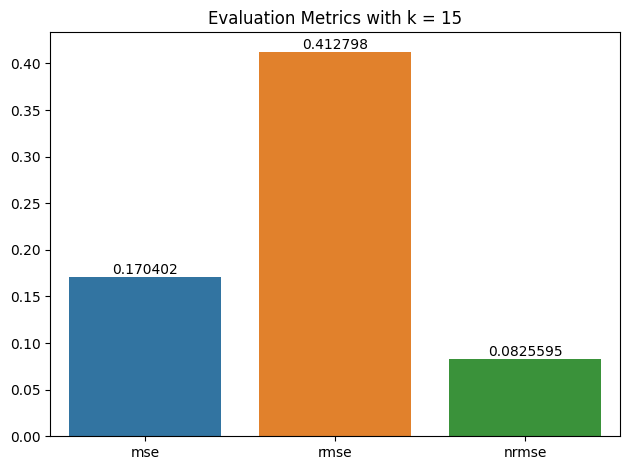

In [31]:

ax = sns.barplot(data=loss_functions)
ax.set_title("Evaluation Metrics with k = 15")
ax.bar_label(ax.containers[0])


plt.tight_layout()
plt.savefig("plot.png", dpi=300)


## Another Versions

In [32]:
class CFRecommender2:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, projects_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.projects_df = projects_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_projects(self, donor_id, projects_to_ignore=[], topn=10):
        # Get and sort the donor's predictions
        sorted_donor_predictions = self.cf_predictions_df[donor_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={donor_id: 'recStrength'})
        
        # Recommend the highest predicted projects that the donor hasn't donated to
        recommendations_df = sorted_donor_predictions[~sorted_donor_predictions['Store'].isin(projects_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        return recommendations_df

In [33]:
preds_df = pd.DataFrame(matrix_reconstructed, 
                           columns = pivot.columns, 
                           index=pivot.index).transpose()

In [34]:
preds_df.head()

User,01 มติมนต์ จํานงค์,113_kammika raksa,1904x,1984whatthehell,212ปาณิตตา ศิริชัย,321 321,53phenix,9ณัฐวลัญช์ พบบุญ,A -yo,A T,...,ไพจิต ศิลารักษ์,ไวไว อิอิ,ປາກເຊແດນງາມ Tubes,ᔕ νιяāкōяη,章詠乾,蔡賢德Karanpon,김주일,남궁진영,박선아,은하
Store,,,,,,,,,,,,,,,,,,,,,
11.11 Gallery and Coffee,-0.015803,0.029215,0.063027,0.071555,0.086291,0.067923,0.304221,0.018933,0.027420,0.489118,...,-0.004854,0.090944,0.060288,-0.003883,-0.003883,0.009961,-0.010948,0.034275,0.197855,0.061930
Abe Specialty Coffee,-0.030304,0.067809,0.028515,0.001583,0.040481,0.028623,0.093605,0.006892,0.011793,0.168515,...,-0.027213,0.062019,0.045388,-0.021770,-0.021770,-0.011679,0.017091,0.014741,0.083780,0.026427
Amarna,-0.001056,0.050623,0.148359,0.112386,0.219765,0.169858,0.784880,0.006795,0.090457,1.152802,...,-0.057452,0.249348,0.008552,-0.045962,-0.045962,0.021373,0.001106,0.113071,0.276864,0.162565
Anna Roasters,0.000390,0.004129,-0.023109,4.971379,0.048251,0.078194,-0.085431,-0.001848,-0.014246,3.908287,...,-0.005676,0.142934,-0.001576,-0.004541,-0.004541,-0.003899,-0.009121,-0.017807,-0.022702,-0.037182
Attaroast,0.003699,0.132550,0.086291,0.069067,0.141565,0.102470,0.452472,0.004163,0.105448,0.653828,...,-0.053491,0.160931,-0.036855,-0.042793,-0.042793,-0.040461,0.041631,0.131810,0.157883,0.103943


In [35]:
pivot[pivot.index == 'Nuunet D.'].idxmax(1)

User
Nuunet D.    NAP's Coffee & Roasters
dtype: object

In [36]:
tes = CFRecommender2(preds_df,pivot)

In [37]:
tes.recommend_projects("1904x")

,Store,recStrength
0,Nap x Warin,0.276800
1,Impression Sunrise,0.257274
2,Saereesook,0.246346
3,Amarna,0.148359
4,ROSIEHOLM,0.113205
5,SongSarn,0.103191
6,LIFE Roasters,0.094664
7,sangob,0.094146
8,BaanHuakham Cafe & Farmstay,0.088122
9,Attaroast,0.086291


# Pytorch Neural Network

In [59]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [60]:
data = df.copy()

In [61]:
data

,Store,User,Rating
0,NAP's Coffee & Roasters,Nuunet D.,5
1,NAP's Coffee & Roasters,vanai sun,3
2,NAP's Coffee & Roasters,Phonanan Seeon,5
3,NAP's Coffee & Roasters,Chavakorn Laophetsakunchai,5
4,NAP's Coffee & Roasters,community man,5
...,...,...,...
3348,Yuanjai Cafe,อาจณรงค์ กลมเกลียว,5
3349,Yuanjai Cafe,은하,5
3350,Yuanjai Cafe,ประจงจิต จันทป,5
3351,Yuanjai Cafe,Chatthawat Warnjai,5


In [62]:
device = get_device()

In [63]:
device

'cpu'

In [131]:

class VanillaMF(nn.Module):
    """
    An implementation of vanilla matrix factorization model.
    """
    
    def __init__(self, n_users: int, n_items: int, latent_dim: int = 10):
        super().__init__()
        
        self.user_embeddings = nn.Embedding(n_users, latent_dim)
        self.item_embeddings = nn.Embedding(n_items, latent_dim)
        
        self.user_h1 = nn.Linear(latent_dim, latent_dim // 2)
        self.item_h1 = nn.Linear(latent_dim, latent_dim // 2)
        
        # self.user_h1_dropout = nn.Dropout(0.25)
        # self.item_h1_dropout = nn.Dropout(0.25)
        
    def forward(self, user_ids: torch.Tensor, item_ids: torch.Tensor) -> torch.Tensor:
        user_emb = self.user_embeddings(user_ids).squeeze(dim=1)  # (batch_size, latent_dim)
        item_emb = self.item_embeddings(item_ids).squeeze(dim=1)  # (batch_size, latent_dim)
        
        user_h1 = self.user_h1(user_emb)
        item_h1 = self.user_h1(item_emb)
        
#         user_h1 = self.user_h1_dropout(user_h1)
#         item_h1 = self.item_h1_dropout(user_h1)
        
        
        
        return (user_h1 * item_h1).sum(dim=1)  # (batch_size, )

    def loss_fn(self, preds: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Simple MSE loss as the loss function for the model.
        
        Args:
            preds: predicted scores
            targets: ground truth scores
            
        Returns:
            MSE of the predictions and the ground truth
        """
        
        # return nn.MSELoss()(preds, targets)  # use package to calculate loss
        return ((preds - targets) ** 2).mean()

In [132]:
class RegularizedMF(VanillaMF):
    """
    Regularized matrix factorization model.
    
    References:
        - https://developers.google.com/machine-learning/recommendation/collaborative/matrix
        - https://colab.research.google.com/github/google/eng-edu/blob/main/ml/recommendation-systems/recommendation-systems.ipynb
    """
    
    def __init__(self, 
                 n_users: int, 
                 n_items: int, 
                 latent_dim: int = 10,
                 reg_coef: float = 0.1,
                 gravity_coeff: float = 1.):
        super().__init__(n_users, n_items, latent_dim)
        
        self.reg_coef = reg_coef
        self.gravity_coeff = gravity_coeff
    
    def regularization_loss(self) -> torch.Tensor:
        """
        Calculate the regularization loss.
        
        Returns:
            regularization loss
        """
        
        user_reg_loss = self.user_embeddings.weight.norm(p=2, dim=1).mean()
        item_reg_loss = self.item_embeddings.weight.norm(p=2, dim=1).mean()
        
        return self.reg_coef * (user_reg_loss + item_reg_loss)
    
    def gravity_loss(self) -> torch.Tensor:
        """
        Calculate the gravity loss.
        
        Returns:
            gravity loss
        """
        
        user_emb = self.user_embeddings.weight  # (n_users, latent_dim)
        item_emb = self.item_embeddings.weight  # (n_items, latent_dim)
        
        denominator = (user_emb.shape[0] * item_emb.shape[0]) * ((user_emb.T @ user_emb) * (item_emb.T @ item_emb)).sum()
        
        return self.gravity_coeff * 1 / denominator

    def loss_fn(self, preds: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        MSE loss with regularization.
        
        Args:
            preds: predicted scores
            targets: ground truth scores
            
        Returns:
            MSE of the predictions and the ground truth
        """
        
        return super().loss_fn(preds, targets) + self.regularization_loss() + self.gravity_loss()

In [133]:
user2idx = {user: idx for idx, user in enumerate(data.User.unique())}
idx2user = {idx: user for user, idx in user2idx.items()}

item2idx = {item: idx for idx, item in enumerate(data.Store.unique())}
idx2item = {idx: item for item, idx in item2idx.items()}

In [134]:
encoded_df = data.copy()

encoded_df["User"] = encoded_df["User"].map(user2idx)
encoded_df["Store"] = encoded_df["Store"].map(item2idx)

pd.pivot_table(encoded_df, values='Rating', index='User', columns='Store')

Store,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
User,,,,,,,,,,,,,,,,,,,,,
0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.0,NaN,5.0,NaN,5.0,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.0,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
2233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
2234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


In [135]:
N_EPOCH = 30
BATCH_SIZE = 512
LEARNING_RATE = 0.02
LATENT_DIM = 3

In [136]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        user_id = self.df.iloc[idx].User
        item_id = self.df.iloc[idx].Store
        rating = self.df.iloc[idx].Rating
        
        return user_id.astype("int"), item_id.astype("int"), rating.astype("float32")

In [137]:
# Train test split
train_df = encoded_df.copy().sample(frac=0.6, random_state=1)
test_df = encoded_df.copy().drop(train_df.index)

# Create dataloader
train_loader = DataLoader(
    CustomDataset(train_df.copy()),
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_loader = DataLoader(
    CustomDataset(test_df.copy()),
    batch_size=test_df.shape[0],
)

In [138]:
model = RegularizedMF(
    n_users=2237, 
    n_items=33,
    latent_dim=LATENT_DIM
).to(get_device())

print(model)

RegularizedMF(
  (user_embeddings): Embedding(2237, 3)
  (item_embeddings): Embedding(33, 3)
  (user_h1): Linear(in_features=3, out_features=1, bias=True)
  (item_h1): Linear(in_features=3, out_features=1, bias=True)
)


In [139]:
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [140]:
loss_hist = []
eval_loss_hist = []

for epoch in range(0, N_EPOCH):
    for i, (user_ids, item_ids, ratings) in enumerate(train_loader):
        user_ids = user_ids.to(device)
        item_ids = item_ids.to(device)
        ratings = ratings.to(device)
        
        # training
        _ = model.train()
        opt.zero_grad()
        
        pred_scores = model(user_ids, item_ids)
        loss = model.loss_fn(pred_scores, ratings)
        
        loss.backward()
        opt.step()
        
        # evaluation
        _ = model.eval()
        
        with torch.no_grad():
            eval_loss = 0
            for j, (user_ids, item_ids, ratings) in enumerate(test_loader):
                user_ids = user_ids.to(device)
                item_ids = item_ids.to(device)
                ratings = ratings.to(device)
                
                pred_scores = model(user_ids, item_ids)
                eval_loss += model.loss_fn(pred_scores, ratings)
                
            eval_loss /= len(test_loader)
        
        loss_hist.append(loss.item())
        eval_loss_hist.append(eval_loss.item())
        
    if epoch % 1 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item():.4f}, Eval Loss: {eval_loss.item():.4f}")

Epoch: 0, Loss: 20.7572, Eval Loss: 20.0037
Epoch: 1, Loss: 19.1801, Eval Loss: 18.7830
Epoch: 2, Loss: 17.7008, Eval Loss: 17.3308
Epoch: 3, Loss: 16.1483, Eval Loss: 15.6716
Epoch: 4, Loss: 15.2951, Eval Loss: 13.9055
Epoch: 5, Loss: 13.1406, Eval Loss: 12.1492
Epoch: 6, Loss: 11.0266, Eval Loss: 10.4612
Epoch: 7, Loss: 9.4275, Eval Loss: 8.8734
Epoch: 8, Loss: 7.4332, Eval Loss: 7.4121
Epoch: 9, Loss: 6.2503, Eval Loss: 6.0867
Epoch: 10, Loss: 5.2431, Eval Loss: 4.9281
Epoch: 11, Loss: 4.0922, Eval Loss: 3.9727
Epoch: 12, Loss: 3.1724, Eval Loss: 3.2358
Epoch: 13, Loss: 2.5550, Eval Loss: 2.6725
Epoch: 14, Loss: 2.0533, Eval Loss: 2.2413
Epoch: 15, Loss: 1.8059, Eval Loss: 1.9030
Epoch: 16, Loss: 1.5024, Eval Loss: 1.6528
Epoch: 17, Loss: 1.2353, Eval Loss: 1.4721
Epoch: 18, Loss: 1.1039, Eval Loss: 1.3477
Epoch: 19, Loss: 1.1216, Eval Loss: 1.2522
Epoch: 20, Loss: 0.9231, Eval Loss: 1.1771
Epoch: 21, Loss: 0.9656, Eval Loss: 1.1198
Epoch: 22, Loss: 0.9058, Eval Loss: 1.0778
Epoch: 

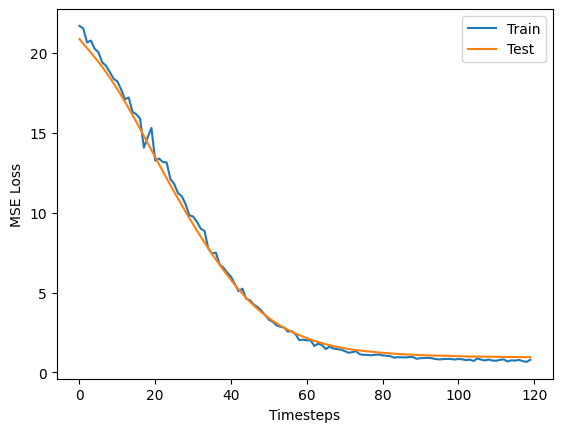

In [141]:
_ = plt.plot(loss_hist, label="Train")
_ = plt.plot(eval_loss_hist, label="Test")
_ = plt.xlabel("Timesteps")
_ = plt.ylabel("MSE Loss")
_ = plt.legend()

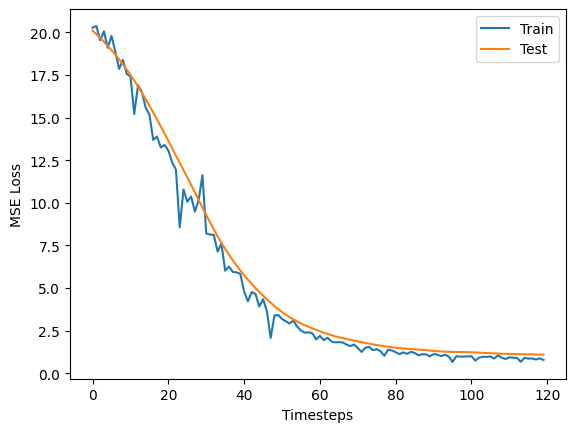

In [75]:
_ = plt.plot(loss_hist, label="Train")
_ = plt.plot(eval_loss_hist, label="Test")
_ = plt.xlabel("Timesteps")
_ = plt.ylabel("MSE Loss")
_ = plt.legend()

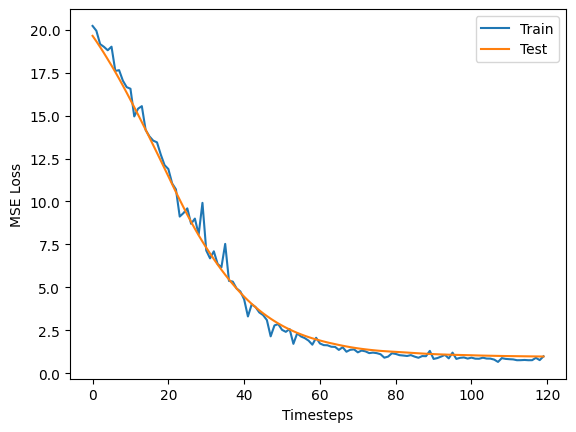

In [40]:
_ = plt.plot(loss_hist, label="Train")
_ = plt.plot(eval_loss_hist, label="Test")
_ = plt.xlabel("Timesteps")
_ = plt.ylabel("MSE Loss")
_ = plt.legend()

In [143]:
user_item_pair = list(product(range(2237), range(33)))
user_item_pair = np.array(user_item_pair)


In [144]:
_ = model.eval()

# Predict scores for all user-item pairs
user_ids = torch.IntTensor(user_item_pair[:, 0].copy()).to(device)
item_ids = torch.IntTensor(user_item_pair[:, 1].copy()).to(device)

pred = model(
    user_ids,
    item_ids
)

user_item_score = pd.DataFrame(user_item_pair.copy(), columns=["User", "Store"])
user_item_score["pred"] = pred.cpu().detach().numpy()


In [145]:
user_item_score

,User,Store,pred
0,0,0,5.391191
1,0,1,5.599518
2,0,2,5.004054
3,0,3,5.267044
4,0,4,5.351558
...,...,...,...
73816,2236,28,5.116271
73817,2236,29,5.340801
73818,2236,30,4.958758
73819,2236,31,5.085126


In [146]:
pd.pivot_table(user_item_score, values='pred', index='User', columns='Store').round(1)

Store,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
User,,,,,,,,,,,,,,,,,,,,,
0,5.4,5.6,5.0,5.3,5.4,5.3,5.6,5.0,4.9,4.9,...,5.1,5.4,4.8,5.2,4.6,5.2,5.4,5.0,5.2,5.4
1,4.6,4.8,4.3,4.5,4.6,4.5,4.7,4.3,4.2,4.2,...,4.3,4.6,4.1,4.4,4.0,4.4,4.6,4.3,4.4,4.6
2,4.7,4.8,4.3,4.6,4.6,4.6,4.8,4.4,4.3,4.3,...,4.4,4.6,4.2,4.5,4.0,4.5,4.7,4.4,4.5,4.7
3,4.4,4.5,4.1,4.3,4.3,4.3,4.5,4.1,4.0,4.0,...,4.1,4.3,3.9,4.2,3.8,4.2,4.4,4.1,4.2,4.4
4,4.9,5.1,4.6,4.8,4.9,4.9,5.1,4.6,4.5,4.5,...,4.7,4.9,4.4,4.8,4.3,4.7,5.0,4.6,4.7,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,5.2,5.4,4.8,5.1,5.2,5.1,5.4,4.8,4.8,4.7,...,4.9,5.2,4.7,5.0,4.5,5.0,5.2,4.8,5.0,5.2
2233,4.3,4.4,4.0,4.2,4.2,4.2,4.4,4.0,3.9,3.9,...,4.0,4.3,3.8,4.1,3.7,4.1,4.3,4.0,4.1,4.3
2234,5.3,5.5,5.0,5.2,5.3,5.3,5.5,5.0,4.9,4.9,...,5.1,5.3,4.8,5.2,4.6,5.1,5.4,5.0,5.1,5.4


In [147]:
# Actual result
pibot = pd.pivot_table(encoded_df, values='Rating', index='User', columns='Store')
pibot

Store,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
User,,,,,,,,,,,,,,,,,,,,,
0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.0,NaN,5.0,NaN,5.0,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.0,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
2233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
2234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


In [221]:
# Recommend top 5 movies for a particular user

user_id = 2200
test  =  user_item_score[user_item_score.User == user_id].sort_values("pred", ascending=False)["Store"].values[:15]

In [222]:
test

array([ 1,  6, 12, 29, 32,  0, 24, 19, 18,  4,  5, 14,  3, 11, 16])

In [223]:
already = pibot[pibot.index == user_id].idxmax(1).values
for k,v in idx2item.items():
    if k in test:
        if k == already[0]:
            pass
        else:
            print(v)
    

NAP's Coffee & Roasters
sangob
LIFE Roasters
Nap x Warin
BalconyKiss Coffee
Anna Roasters
Attaroast
BaanHuakham Cafe & Farmstay
Blues Coffee
Bossa cafe
GODFATHER COFFEE
Impression Sunrise
REDCOFFEE
Snoopcat Cafe
Yuanjai Cafe


In [202]:
test

array([ 1,  6, 12, 29, 32,  0, 24, 19, 18,  4,  5, 14,  3, 11, 16])